In [1]:
!nvidia-smi

Mon Jul 24 13:45:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install catboost iterative-stratification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 5.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ===================================================================
#  Library
# ===================================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import warnings
warnings.simplefilter("ignore")

import unicodedata

from catboost import CatBoostRegressor, Pool, metrics

In [5]:
# ===================================================================
#  CFG
# ===================================================================
class CFG:
    seed = 42
    n_splits = 10
    data_dir = "/content/drive/MyDrive/signate_StudentCup2023/data/"
    target_bins = 10
    year_bins = 10
    num_boost_round = 10000
    stopping_rounds = 500
    device_cat = "cuda"
    save_dir = "/content/drive/MyDrive/signate_StudentCup2023/exp/"
    filename = "exp002"

In [6]:
# ===================================================================
#  Utils
# ===================================================================
def seed_everything(seed):
    """fix random factors"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


def get_score(y_true, y_pred):
    """get MAPE score"""
    score = mean_absolute_percentage_error(y_true, y_pred)
    return score * 100

In [7]:
# ===================================================================
#  Data Loading
# ===================================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)

In [8]:
# ===================================================================
#  feature_engineering
# ===================================================================
# region

# year
def pre_year(df: pd.DataFrame):
    year_dict = {
        2999:1999,
        3008:2008,
        3015:2015,
        3017:2017,
        3011:2011,
        3019:2019,
    }
    df["year"] = df["year"].replace(year_dict)
    return df

all_data = pre_year(all_data)

# manufacturer
def convert_full_to_half(row):
    return unicodedata.normalize('NFKC', row)

all_data["manufacturer"] = all_data["manufacturer"].str.lower().apply(convert_full_to_half)

# condition

# cylinders

# fuel

# odometer

# title_status

# transmission

# drive

# size
def pre_size(df: pd.DataFrame):
    size_dict = {
        "fullーsize":"full-size",
        "midーsize":"mid-size",
        "subーcompact":"sub-compact",
        "full−size":"full-size",
        "mid−size":"mid-size"
    }
    df["size"] = df["size"].replace(size_dict)
    return df

all_data = pre_size(all_data)

# type

# paint_color

# state

In [9]:
CFG.use_features = ['region', 'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
                    'transmission', 'drive', 'size', 'type', 'paint_color', 'state']

CFG.categorical_features = ['region', 'manufacturer', 'condition', 'cylinders', 'fuel', 'title_status',
                            'transmission', 'drive', 'size', 'type', 'paint_color', 'state']

In [10]:
for col in CFG.categorical_features:
    all_data[col] = all_data[col].fillna(-1).astype("category")

In [11]:
# ===================================================================
#  train test split
# ===================================================================
train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)


train.sort_values(by="id", ignore_index=True, inplace=True)
train["year_map"] = pd.cut(train["year"], bins=CFG.year_bins, labels=False)
train["price_map"] = pd.cut(train["price"], bins=CFG.target_bins, labels=False)

kf = MultilabelStratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (_, val) in enumerate(kf.split(X=train, y=train[["year_map", "price_map"]])):
    train.loc[val, "fold"] = i

train["fold"].value_counts()

0.0    2754
8.0    2754
6.0    2753
4.0    2753
2.0    2753
5.0    2753
9.0    2753
1.0    2753
3.0    2753
7.0    2753
Name: fold, dtype: int64

In [12]:
# ===================================================================
#  model
# ===================================================================
preds, oof_df, feature_importance_df = [], pd.DataFrame(), pd.DataFrame()
feature_importance_df["feature"] = CFG.use_features
print(train.shape)
for fold in range(CFG.n_splits):
    X_train = train[train["fold"] != fold].reset_index(drop=True)
    X_valid = train[train["fold"] == fold].reset_index(drop=True)

    # params
    cat_param = {
        "eval_metric": metrics.MAPE(),
        "random_seed": CFG.seed,
        "logging_level": 'Silent',
        "od_type": "Iter",
        "od_wait": CFG.stopping_rounds,
        "use_best_model": True,
        "task_type": 'GPU' if CFG.device_cat == "cuda" else "CPU"
    }

    y_train = X_train["price"].values
    X_train = X_train[CFG.use_features]
    id_ = X_valid["id"].values
    y_valid = X_valid["price"].values
    X_valid = X_valid[CFG.use_features]

    # get categorical_features_indices
    cols = X_train.columns.values
    sidx = np.argsort(cols)
    categorical_features_indices = sidx[np.searchsorted(a=cols, v=CFG.categorical_features, sorter=sidx)]

    # train
    model = CatBoostRegressor(**cat_param)
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    validate_pool = Pool(X_valid, y_valid, cat_features=categorical_features_indices)
    model.fit(train_pool, eval_set=validate_pool)

    # feature importance
    feature_importance_df[f"importance_fold{fold}"] = model.feature_importances_

    # eval
    X_valid[f"pred"] = model.predict(X_valid)
    X_valid["price"] = y_valid
    X_valid["id"] = id_
    print(f"fold{fold}:", get_score(y_true=X_valid["price"], y_pred=X_valid["pred"]))

    # concat
    oof_df = pd.concat([oof_df, X_valid], ignore_index=True)

    # pred test
    preds.append(model.predict(test[CFG.use_features]))

print('\033[32m'+"====== CV score ======"+'\033[0m')
print('\033[32m'+f'{get_score(oof_df["price"], oof_df["pred"])}'+'\033[0m')
predictions = np.mean(preds, axis=0)

(27532, 20)
fold0: 65.12347532947487
fold1: 66.14906033299322
fold2: 65.53744016957552
fold3: 63.127774675061445
fold4: 65.80573528779162
fold5: 64.26104959989453
fold6: 64.24571959899316
fold7: 63.792466149148076
fold8: 65.24382778885632
fold9: 63.925181315017085
====== CV score ======
64.72120662038989


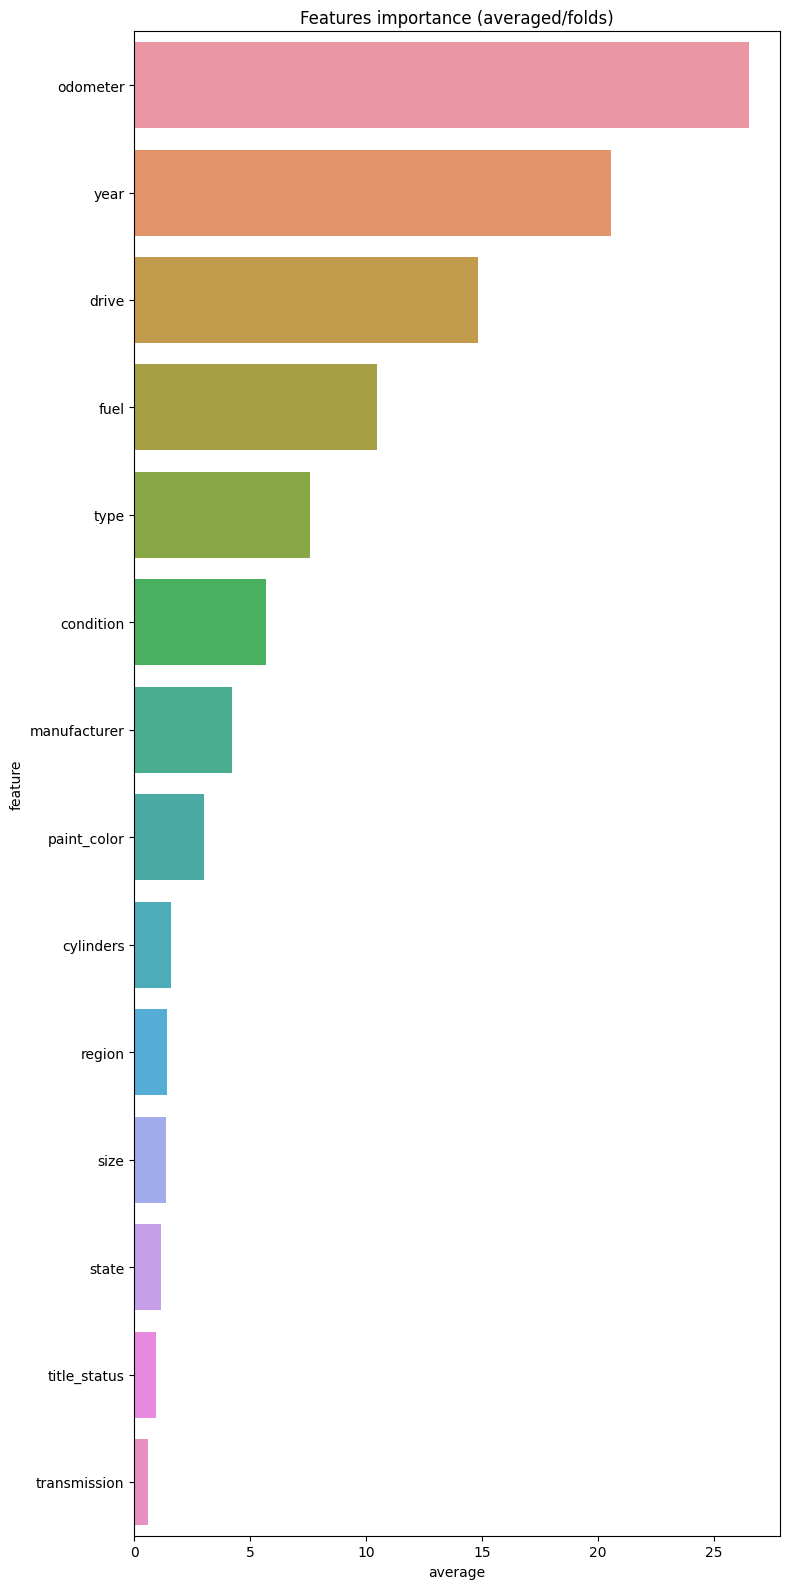

In [13]:
# ===================================================================
#  plot feature importance
# ===================================================================
feature_importance_df.fillna(value=0, inplace=True)
feature_importance_df["average"] = feature_importance_df.loc[:, 'importance_fold0':f'importance_fold{CFG.n_splits-1}'].mean(axis=1)
best_features = feature_importance_df[["feature", "average"]].groupby("feature", as_index=False).mean().sort_values(by="average", ascending=False).head(50)
plt.figure(figsize=(8, 16))
sns.barplot(x="average", y="feature", data=best_features)
plt.title('Features importance (averaged/folds)')
plt.tight_layout()

In [14]:
test["pred"] = predictions
test["pred"].head()

0    13786.588072
1     8465.032466
2     6556.600787
3    27742.763169
4     9939.926308
Name: pred, dtype: float64

In [15]:
test["pred"].min(), test["pred"].max()

(1960.5260652118013, 51466.87758472995)

In [16]:
test[["id", "pred"]].to_csv(CFG.save_dir+CFG.filename+".csv", index=False, header=None)

In [17]:
oof_df.to_csv(CFG.save_dir+CFG.filename+"_oof_df.csv", index=False)